In [204]:
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [205]:
#Reading the data
akbank_data = pd.read_csv(
    "C:\\Users\\ERALP\\OneDrive\\Desktop\\Software Engineering\\SWE599---Financial-Time-Series-Volatility-and-Return-Forecasting\\Code\\akbank_data.csv")
akbank_data['Date'] = akbank_data['Date'].str.replace('/', '-')

print(akbank_data.head())
print(akbank_data.tail())
print(akbank_data.shape)
print(akbank_data.describe())
print(akbank_data.info())
print(akbank_data.columns)



        Date      Hour  Open  High   Low  Close
0  12-2-2019   9:00:00  6.57  6.57  6.57   6.57
1  12-2-2019  10:00:00  6.57  6.59  6.51   6.52
2  12-2-2019  11:00:00  6.52  6.58  6.51   6.57
3  12-2-2019  12:00:00  6.57  6.57  6.46   6.48
4  12-2-2019  13:00:00  6.49  6.49  6.49   6.49
            Date      Hour   Open   High    Low  Close
9987  21-02-2023  17:00:00  16.12  16.14  15.80  15.92
9988  21-02-2023  18:00:00  15.90  15.90  15.90  15.90
9989  22-02-2023   9:00:00  15.89  15.89  15.89  15.89
9990  22-02-2023  10:00:00  15.88  16.23  15.82  16.13
9991  22-02-2023  11:00:00  16.13  16.29  16.09  16.17
(9992, 6)
              Open         High          Low        Close
count  9992.000000  9992.000000  9992.000000  9992.000000
mean      7.552604     7.586324     7.514919     7.551290
std       3.433072     3.460357     3.401024     3.431051
min       4.310000     4.350000     4.280000     4.310000
25%       5.440000     5.460000     5.420000     5.440000
50%       6.490000     6

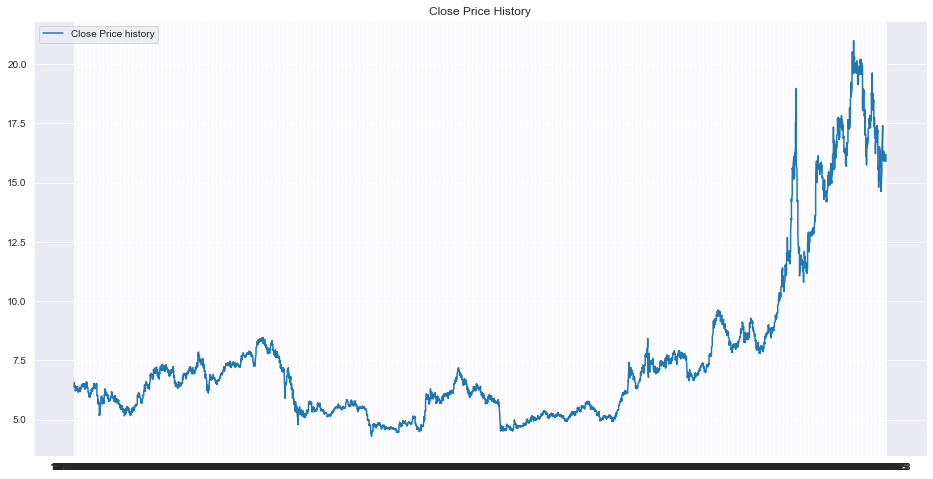

In [206]:
plt.figure(figsize=(16, 8))
plt.plot(akbank_data['Date'], akbank_data['Close'], label='Close Price history')
plt.title('Close Price History')
plt.legend()
plt.show()

In [207]:
# print(akbank_data.columns)
#
# akbank_data['DateHour'] = pd.to_datetime(akbank_data['Date'] + " " + akbank_data['Hour'])
#
# print(akbank_data.columns)
# akbank_data.drop(['Date', 'Hour'], axis=1, inplace=True)
#
# """ I want to change the order of the columns. I want to put the DateHour column to the first column."""
#
# akbank_data['DateHour'] = akbank_data['DateHour'].astype('int64') / 10**9
#
#
# cols = akbank_data.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# akbank_data = akbank_data[cols]
#
#
# print(akbank_data.head())
# print(akbank_data.tail())
# print(akbank_data.shape)
# print(akbank_data.describe())
# print(akbank_data.info())
# print(akbank_data.columns)


In [208]:
# plt.figure(figsize=(16,8))
# plt.plot(akbank_data['DateHour'], akbank_data['Close'], label='Close Price history')
# plt.title('Close Price History')
# plt.legend()
# plt.show()

In [209]:
scaler = MinMaxScaler()

close_price = akbank_data['Close'].values.reshape(-1, 1)
scaled_close_price = scaler.fit_transform(close_price)
scaled_close_price = scaled_close_price[~np.isnan(scaled_close_price)]
scaled_close_price = scaled_close_price.reshape(-1, 1)

# The scaler expects the data to be shaped as (x, y), where x is the number of rows and y is the number of columns.

print(scaled_close_price.shape)


(9992, 1)


In [210]:
Sequence_length = 45


def to_sequences(data, seq_length):
    d = []
    for index in range(len(data) - seq_length):
        d.append(data[index: index + seq_length])
    return np.array(d)


def preprocess(data_raw, seq_length, train_split):
    data = to_sequences(data_raw, seq_length)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close_price, Sequence_length, train_split=0.80)

print(X_train.shape, X_test.shape)

(7957, 44, 1) (1990, 44, 1)


In [212]:
from keras.layers import Dropout, Bidirectional, Activation
from unicodedata import bidirectional
from tensorflow.python import keras
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout
from tensorflow.keras import Sequential


dropout = 0.2

window_size = Sequence_length - 1
model = keras.Sequential()

model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1])))

model.add(Dropout(dropout))

# 1st Hidden layer
model.add(Bidirectional(LSTM((window_size * 2), return_sequences=True)))
model.add(Dropout(rate=dropout))
# 2nd Hidden layer
model.add(Bidirectional(LSTM(window_size, return_sequences=False)))
# output layer
model.add(Dense(units=1))
model.add(Activation('linear'))
"""Output layer has a single neuron (predicted Bitcoin price). We use Linear activation function which activation is proportional to the input."""
BATCH_SIZE = 64
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1)
# shuffle not advisable during training of Time Series


Epoch 1/50
112/112 [==============================] - 47s 226ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 2/50
112/112 [==============================] - 24s 213ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 3/50
112/112 [==============================] - 21s 184ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 4/50
112/112 [==============================] - 20s 176ms/step - loss: 6.0788e-04 - val_loss: 2.3668e-04
Epoch 5/50
112/112 [==============================] - 21s 185ms/step - loss: 9.2438e-05 - val_loss: 1.2508e-04
Epoch 6/50
112/112 [==============================] - 21s 186ms/step - loss: 1.0268e-04 - val_loss: 1.2414e-04
Epoch 7/50
112/112 [==============================] - 21s 187ms/step - loss: 9.7513e-05 - val_loss: 1.1029e-04
Epoch 8/50
112/112 [==============================] - 21s 189ms/step - loss: 1.0797e-04 - val_loss: 1.1003e-04
Epoch 9/50
112/112 [==============================] - 22s 199ms/step - loss: 1.1981e-04 - val_loss: 1.1549e-04
Epoch 10/50
112/112 [====

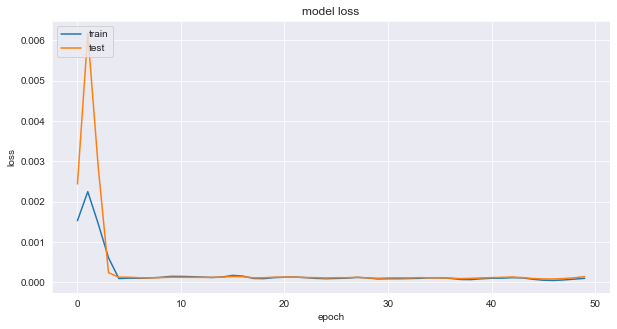

In [213]:
# history for loss
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [215]:
# prediction on test data
y_pred = model.predict(X_test)
# invert the test to original values
y_test_inverse = DataFrame(scaler.inverse_transform(y_test))
# assigning datetime

y_test_inverse.index = akbank_data.index[-len(y_test):]
print('Test data:',)
print(y_test_inverse.tail(3)); print();
# invert the prediction to understandable values
y_pred_inverse = DataFrame(scaler.inverse_transform(y_pred))
# assigning datetime
y_pred_inverse.index = y_test_inverse.index
print('Prediction data:',)
print(y_pred_inverse.tail(3))

Test data:
          0
9989  15.90
9990  15.89
9991  16.13

Prediction data:
              0
9989  12.216918
9990  12.190159
9991  12.155943


In [223]:
from sklearn.metrics import r2_score


print("R-Square Value:", r2_score(y_test, y_pred), "\n")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred), "\n")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred), "\n")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)), "\n")



R-Square Value: 0.3016979944226018 

Mean Absolute Error: 0.14431415048652468 

Mean Squared Error: 0.03933862980994332 

Root Mean Squared Error: 0.1983396828926156 



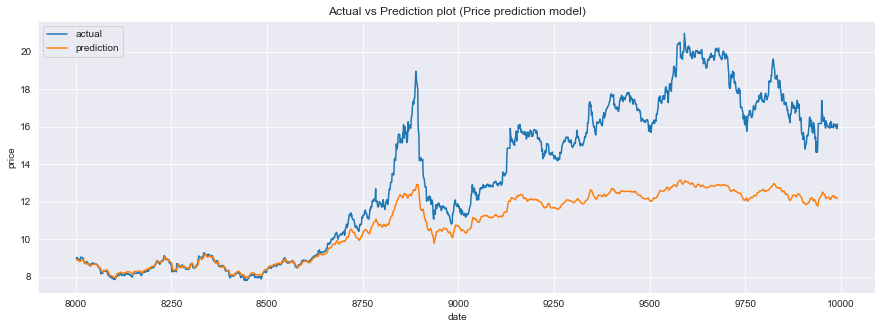

In [218]:
plt.figure(figsize = (15,5))
plt.plot(y_test_inverse)
plt.plot(y_pred_inverse)
plt.title('Actual vs Prediction plot (Price prediction model)')
plt.ylabel('price')
plt.xlabel('date')
plt.legend(['actual', 'prediction'], loc='upper left')
plt.show()